In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
from mlmicrophysics.metrics import hellinger_distance, r2_corr, root_mean_squared_error
from sklearn.metrics import mean_absolute_error, confusion_matrix
from keras.models import load_model

Using TensorFlow backend.


In [5]:
ls /glade/p/cisl/aiml/dgagne/cam_run5_models_20190726/

dnn_classifier_scores.csv  dnn_nr_neg_fortran.nc     input_scale_values.csv
dnn_nc_class.h5            dnn_nr_pos.h5             meta_test.csv
dnn_nc_class_fortran.nc    dnn_nr_pos_fortran.nc     output_scale_values.csv
dnn_nc_pos.h5              dnn_qr_class.h5           test_cam_labels.csv
dnn_nc_pos_fortran.nc      dnn_qr_class_fortran.nc   test_cam_values.csv
dnn_nr_class.h5            dnn_qr_pos.h5             test_prediction_labels.csv
dnn_nr_class_fortran.nc    dnn_qr_pos_fortran.nc     test_prediction_values.csv
dnn_nr_neg.h5              dnn_regressor_scores.csv


In [2]:
ls /glade/p/cisl/aiml/dgagne

cam_mp_files_run2_big_csv/       goes16_nc/
cam_mp_files_run2_csv/           mkdir/
cam_mp_files_run3_csv/           TAU_ML_v2/
cam_mp_files_run5_big_csv/       TAU_ML_v2.cam.h0.0001-01.nc
cam_mp_files_run5_full_csv/      TAU_ML_v2.cam.h0.0001-02.nc
cam_run2_models/                 TAU_ML_v2.cam.h0.0001-03.nc
cam_run2_models_20190510/        TAU_ML_v2.cam.h0.0001-04.nc
cam_run2_models_20190512/        TAU_ML_v2.cam.h0.0001-05.nc
cam_run2_models_20190512.tar.gz  TAU_run2/
cam_run2_nn_predictions.csv      TAU_run3/
cam_run5_models_20190524/        TAU_run4_plots/
cam_run5_models_20190726/        TAU_run5/
cam_run5_models_20190726.tar.gz  TAU_run5_full/


In [2]:
data_path = "/glade/p/cisl/aiml/dgagne/cam_run5_models_20190726/"
test_pred_labels = pd.read_csv(join(data_path, "test_prediction_labels.csv"), index_col="index") 
test_pred_values = pd.read_csv(join(data_path, "test_prediction_values.csv"), index_col="index") 
test_cam_labels = pd.read_csv(join(data_path, "test_cam_labels.csv"), index_col="index")
test_cam_values = pd.read_csv(join(data_path, "test_cam_values.csv"), index_col="index") 
meta_test = pd.read_csv(join(data_path, "meta_test.csv"), index_col="index")

/glade/u/home/dgagne/miniconda3/envs/tf2/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
test_pred_values.columns

Index(['qrtend_TAU_1', 'nctend_TAU_1', 'nrtend_TAU_-1', 'nrtend_TAU_1'], dtype='object')

In [3]:
mg2_test = meta_test.loc[:, ["qrtend_MG2", "nctend_MG2", "nrtend_MG2"]]
mg2_test.loc[mg2_test["qrtend_MG2"] > 0, "qrtend_MG2"] = np.log10(mg2_test.loc[mg2_test["qrtend_MG2"] > 0, "qrtend_MG2"])
mg2_test.loc[mg2_test["nctend_MG2"] < 0, "nctend_MG2"] = np.log10(-mg2_test.loc[mg2_test["nctend_MG2"] < 0, "nctend_MG2"])
mg2_test.loc[mg2_test["nrtend_MG2"] < 0, "nrtend_MG2"] = np.log10(-mg2_test.loc[mg2_test["nrtend_MG2"] < 0, "nrtend_MG2"])
mg2_test.loc[mg2_test["nrtend_MG2"] > 0, "nrtend_MG2"] = np.log10(mg2_test.loc[mg2_test["nrtend_MG2"] > 0, "nrtend_MG2"])


In [5]:
reg_scores = pd.read_csv(join(data_path, "dnn_regressor_scores.csv"), index_col="Output")
print(reg_scores)

                   rmse       mae        r2  hellinger
Output                                                
qrtend_TAU_1   0.195849  0.095788  0.991323   0.000453
nctend_TAU_1   0.187454  0.111714  0.995448   0.001489
nrtend_TAU_-1  0.154587  0.081380  0.995528   0.000604
nrtend_TAU_1   0.274484  0.178448  0.978361   0.001176


In [7]:
scores = {"rmse": root_mean_squared_error, "mae": mean_absolute_error, 
          "r2": r2_corr, "hellinger": hellinger_distance}
mg2_scores = pd.DataFrame(0, columns=reg_scores.columns, index=reg_scores.index)
for score in reg_scores.columns:
    mg2_scores.loc["qrtend_TAU_1", 
                   score] = scores[score](test_cam_values.loc[test_cam_labels["qrtend_TAU"] == 1, "qrtend_TAU"],
                                                      mg2_test.loc[test_cam_labels["qrtend_TAU"] == 1, "qrtend_MG2"])
    mg2_scores.loc["nctend_TAU_1", 
                   score] = scores[score](test_cam_values.loc[test_cam_labels["nctend_TAU"] == 1, "nctend_TAU"],
                                                      mg2_test.loc[test_cam_labels["nctend_TAU"] == 1, "nctend_MG2"])
    mg2_scores.loc["nrtend_TAU_-1", 
                   score] = scores[score](test_cam_values.loc[test_cam_labels["nrtend_TAU"] == -1, "nrtend_TAU"],
                                                      mg2_test.loc[test_cam_labels["nrtend_TAU"] == -1, "nrtend_MG2"])
    mg2_scores.loc["nrtend_TAU_1", 
                   score] = scores[score](test_cam_values.loc[test_cam_labels["nrtend_TAU"] == 1, "nrtend_TAU"],
                                                      mg2_test.loc[test_cam_labels["nrtend_TAU"] == 1, "nrtend_MG2"])

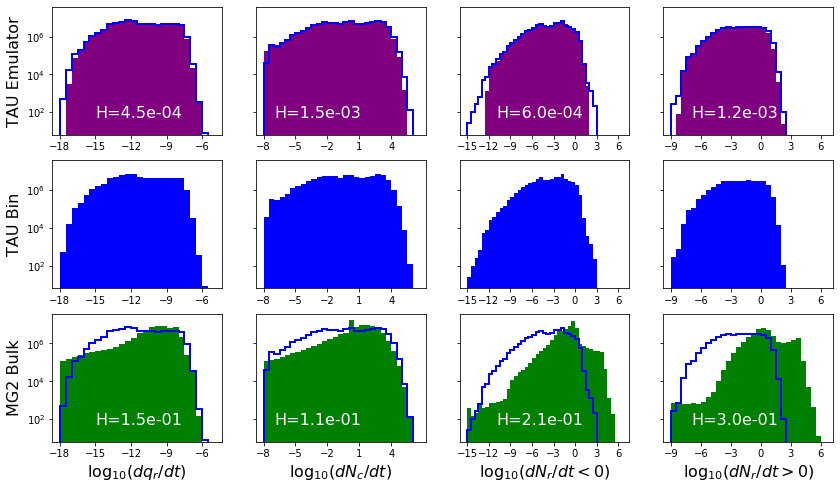

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(14, 8), sharey=True)
bins = dict(qr=np.arange(-18, -4.5, 0.5),
            nc=np.arange(-8, 7, 0.5),
            nr_neg=np.arange(-15, 7, 0.5),
            nr_pos=np.arange(-9, 7, 0.5))
ticks = dict(qr=np.arange(-18, -4, 3),
             nc=np.arange(-8, 7, 3),
             nr_neg=np.arange(-15, 7, 3),
             nr_pos=np.arange(-9, 7, 3))
y_labels = ["TAU Emulator", "TAU Bin", "MG2 Bulk"]
x_labels = ["$\log_{10}(dq_r/dt)$", "$\log_{10}(dN_c/dt)$", 
            "$\log_{10}(dN_r/dt < 0)$", "$\log_{10}(dN_r/dt > 0)$"]
axes[0, 0].hist(test_pred_values.loc[test_cam_labels["qrtend_TAU"] == 1, "qrtend_TAU_1"], bins=bins["qr"], color="purple")
axes[1, 0].hist(test_cam_values.loc[test_cam_labels["qrtend_TAU"] == 1, "qrtend_TAU"], bins=bins["qr"], color="blue")
axes[2, 0].hist(mg2_test.loc[test_cam_labels["qrtend_TAU"] == 1, "qrtend_MG2"], 
                bins=bins["qr"], color="green")
axes[0, 0].hist(test_cam_values.loc[test_cam_labels["qrtend_TAU"] == 1, "qrtend_TAU"], 
                bins=bins["qr"], color="blue", histtype="step", lw=2)
axes[2, 0].hist(test_cam_values.loc[test_cam_labels["qrtend_TAU"] == 1, "qrtend_TAU"], 
                bins=bins["qr"], color="blue", histtype="step", lw=2)

axes[0, 0].set_yscale("log")
axes[0, 1].hist(test_pred_values.loc[test_cam_labels["nctend_TAU"] == 1, "nctend_TAU_1"], bins=bins["nc"], color="purple")
axes[1, 1].hist(test_cam_values.loc[test_cam_labels["nctend_TAU"] == 1, "nctend_TAU"], bins=bins["nc"], color="blue")
axes[2, 1].hist(mg2_test.loc[test_cam_labels["nctend_TAU"] == 1, "nctend_MG2"], 
                bins=bins["nc"], color="green")
axes[0, 1].hist(test_cam_values.loc[test_cam_labels["nctend_TAU"] == 1, "nctend_TAU"], 
                bins=bins["nc"], color="blue", histtype="step", lw=2)
axes[2, 1].hist(test_cam_values.loc[test_cam_labels["nctend_TAU"] == 1, "nctend_TAU"], 
                bins=bins["nc"], color="blue", histtype="step", lw=2)

axes[0, 2].hist(test_pred_values.loc[test_cam_labels["nrtend_TAU"] == -1, "nrtend_TAU_-1"], bins=bins["nr_neg"], color="purple")
axes[1, 2].hist(test_cam_values.loc[test_cam_labels["nrtend_TAU"] == -1, "nrtend_TAU"], bins=bins["nr_neg"], color="blue")
axes[2, 2].hist(mg2_test.loc[test_cam_labels["nrtend_TAU"] == -1, "nrtend_MG2"], 
                bins=bins["nr_neg"], color="green")
axes[0, 2].hist(test_cam_values.loc[test_cam_labels["nrtend_TAU"] == -1, "nrtend_TAU"], 
                bins=bins["nr_neg"], color="blue", histtype="step", lw=2)
axes[2, 2].hist(test_cam_values.loc[test_cam_labels["nrtend_TAU"] == -1, "nrtend_TAU"], 
                bins=bins["nr_neg"], color="blue", histtype="step", lw=2)


axes[0, 3].hist(test_pred_values.loc[test_cam_labels["nrtend_TAU"] == 1, "nrtend_TAU_1"], bins=bins["nr_pos"], color="purple")
axes[1, 3].hist(test_cam_values.loc[test_cam_labels["nrtend_TAU"] == 1, "nrtend_TAU"], bins=bins["nr_pos"], color="blue")
axes[2, 3].hist(mg2_test.loc[test_cam_labels["nrtend_TAU"] == 1, "nrtend_MG2"], 
                bins=bins["nr_pos"], color="green")
axes[0, 3].hist(test_cam_values.loc[test_cam_labels["nrtend_TAU"] == 1, "nrtend_TAU"], 
                bins=bins["nr_pos"], color="blue", histtype="step", lw=2)
axes[2, 3].hist(test_cam_values.loc[test_cam_labels["nrtend_TAU"] == 1, "nrtend_TAU"], 
                bins=bins["nr_pos"], color="blue", histtype="step", lw=2)

for i in range(3):
    for j, out in enumerate(["qr", "nc", "nr_neg", "nr_pos"]):
        axes[i, j].set_xticks(ticks[out])
    axes[i, 0].set_ylabel(y_labels[i], fontsize=16)
x_pos = [-15, -7, -11, -7]
for j in range(4):
    axes[0, j].text(x_pos[j], 50, f"H={reg_scores.iloc[j, 3]:1.1e}", fontsize=16, color='w')
    axes[2, j].text(x_pos[j], 50, f"H={mg2_scores.iloc[j, 3]:1.1e}", fontsize=16, color='w')

    axes[2, j].set_xlabel(x_labels[j], fontsize=16)
plt.savefig(join(data_path, "tendency_hist.pdf"), bbox_inches="tight")
        

/glade/u/home/dgagne/miniconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


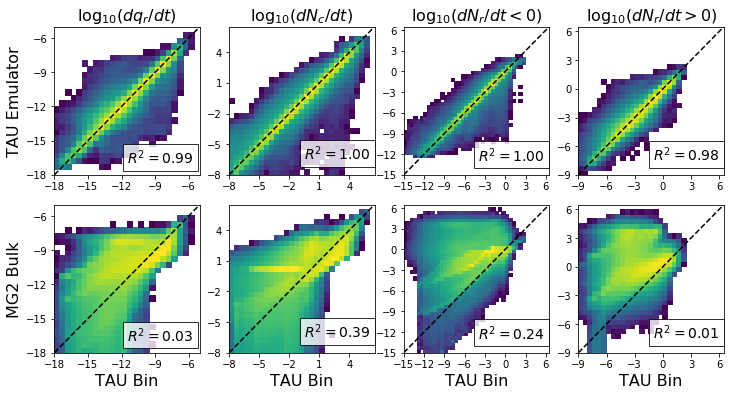

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
hist2d_ylabels = ["TAU Emulator", "MG2 Bulk"]
_ = axes[0, 0].hist2d(test_cam_values.loc[test_cam_labels["qrtend_TAU"] == 1, "qrtend_TAU"],
                  test_pred_values.loc[test_cam_labels["qrtend_TAU"] == 1, "qrtend_TAU_1"],
                  bins=bins["qr"], cmin=1, norm=LogNorm())
_ =axes[0, 1].hist2d(test_cam_values.loc[test_cam_labels["nctend_TAU"] == 1, "nctend_TAU"],
                  test_pred_values.loc[test_cam_labels["nctend_TAU"] == 1, "nctend_TAU_1"],
                  bins=bins["nc"], cmin=1, norm=LogNorm())
_=axes[0, 2].hist2d(test_cam_values.loc[test_cam_labels["nrtend_TAU"] == -1, "nrtend_TAU"],
                  test_pred_values.loc[test_cam_labels["nrtend_TAU"] == -1, "nrtend_TAU_-1"],
                  bins=bins["nr_neg"], cmin=1, norm=LogNorm())
_=axes[0, 3].hist2d(test_cam_values.loc[test_cam_labels["nrtend_TAU"] == 1, "nrtend_TAU"],
                  test_pred_values.loc[test_cam_labels["nrtend_TAU"] == 1, "nrtend_TAU_1"],
                  bins=bins["nr_pos"], cmin=1, norm=LogNorm())
_ = axes[1, 0].hist2d(test_cam_values.loc[test_cam_labels["qrtend_TAU"] == 1, "qrtend_TAU"],
                    mg2_test.loc[test_cam_labels["qrtend_TAU"] == 1, "qrtend_MG2"],
                  bins=bins["qr"], cmin=1, norm=LogNorm())
_ =axes[1, 1].hist2d(test_cam_values.loc[test_cam_labels["nctend_TAU"] == 1, "nctend_TAU"],
                     mg2_test.loc[test_cam_labels["nctend_TAU"] == 1, "nctend_MG2"],
                  bins=bins["nc"], cmin=1, norm=LogNorm())
_=axes[1, 2].hist2d(test_cam_values.loc[test_cam_labels["nrtend_TAU"] == -1, "nrtend_TAU"],
                    mg2_test.loc[test_cam_labels["nrtend_TAU"] == -1, "nrtend_MG2"],
                  bins=bins["nr_neg"], cmin=1, norm=LogNorm())
_=axes[1, 3].hist2d(test_cam_values.loc[test_cam_labels["nrtend_TAU"] == 1, "nrtend_TAU"],
                    mg2_test.loc[test_cam_labels["nrtend_TAU"] == 1, "nrtend_MG2"],
                  bins=bins["nr_pos"], cmin=1, norm=LogNorm())
for a, out in enumerate(["qr", "nc", "nr_neg", "nr_pos"]):
    axes[0, a].plot(bins[out], bins[out], 'k--')
    axes[1, a].plot(bins[out], bins[out], 'k--')

for i in range(2):
    for j, out in enumerate(["qr", "nc", "nr_neg", "nr_pos"]):
        axes[i, j].set_xticks(ticks[out])
        axes[i, j].set_yticks(ticks[out])

    axes[i, 0].set_ylabel(hist2d_ylabels[i], fontsize=16)
for j, out in enumerate(["qr", "nc", "nr_neg", "nr_pos"]):
    axes[1, j].set_xlabel("TAU Bin", fontsize=16)
    axes[0, j].set_title(x_labels[j], fontsize=16)
    axes[0, j].text(bins[out][int(bins[out].size * 0.51)], 
                    bins[out][int(bins[out].size * 0.1)], f"$R^2=${reg_scores.iloc[j, 2]:0.2f}", fontsize=14, bbox=dict(facecolor='white', alpha=0.8))
    axes[1, j].text(bins[out][int(bins[out].size * 0.51)], 
                    bins[out][int(bins[out].size * 0.1)], f"$R^2=${mg2_scores.iloc[j, 2]:0.2f}", fontsize=14, bbox=dict(facecolor='white', alpha=0.8))
plt.savefig(join(data_path, "tendency_hist2d.pdf"), bbox_inches="tight")


In [14]:
test_pred_values.shape

(167147803, 4)

In [49]:
bins["nr_pos"].size

32

In [18]:
mg2_scores

,rmse,mae,r2,hellinger
Output,,,,
qrtend_TAU_1,4.706915,2.652418,0.004475,0.110987
nctend_TAU_1,2.556131,1.895779,0.411131,0.116597
nrtend_TAU_-1,3.945603,3.326279,0.125331,0.336990
nrtend_TAU_1,3.414961,2.808220,0.031346,0.351811


In [22]:
cm_qr = confusion_matrix(test_cam_labels["qrtend_TAU"], test_pred_labels["qrtend_TAU"])

In [29]:
cm_qr / cm_qr.sum()

array([[0.64200146, 0.01549923],
       [0.01454044, 0.32795886]])

In [33]:
cm_nc = confusion_matrix(test_cam_labels["nctend_TAU"], test_pred_labels["nctend_TAU"])

In [34]:
cm_nc / cm_nc.sum()

array([[0.50250749, 0.00621515],
       [0.0029789 , 0.48829846]])

In [36]:
cm_nr = confusion_matrix(test_cam_labels["nrtend_TAU"], test_pred_labels["nrtend_TAU"])

In [39]:
cm_nr_per = cm_nr / cm_nr.sum() * 100

In [41]:
cm_nr_per.sum(axis=1)

array([31.53037573, 48.47151222, 19.99811205])

In [44]:
np.diag(cm_nr_per).sum()

96.36197021098616

In [76]:
mod = load_model(join(data_path, "dnn_nc_pos.h5"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [77]:
mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_00 (Dense)             (None, 30)                180       
_________________________________________________________________
dense_01 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_02 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_03 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_04 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_05 (Dense)             (None, 30)                930       
__________

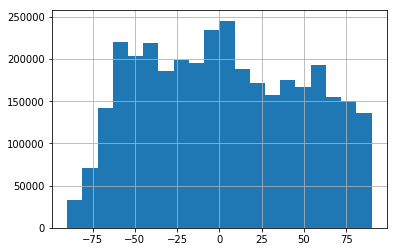

In [82]:
meta_test["lat"].hist(bins=20)

In [96]:
qr_label_pos = test_cam_labels["qrtend_TAU"] == 1
combined = pd.merge(meta_test.loc[qr_label_pos, "lat"], 
                    pd.DataFrame(test_pred_values.loc[qr_label_pos, "qrtend_TAU_1"] - 
                    test_cam_values.loc[qr_label_pos, "qrtend_TAU"], columns=["qrtend_TAU_diff"]), 
                    left_index=True, right_index=True)

In [97]:
combined["lat_round"] = np.round()

,lat,qrtend_TAU_diff
index,,
9,-88.115183,2.129473
11,-88.115183,0.067636
12,-88.115183,0.431636
15,-88.115183,1.482628
16,-88.115183,1.287512
22,-87.172775,1.281260
23,-87.172775,0.647418
42,-86.230366,0.026662
43,-86.230366,0.147254
